<a href="https://colab.research.google.com/github/psahai10/API_Project/blob/master/AI_Fellowship_Pankaj_Sahai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Fellowship Challenge: Submission from Pankaj Sahai
### Challenge: Use the STL10 dataset and a pretrained ResNet 18 to demonstrate why initial layers are frozen during the first few epochs of transfer learning. Does your model do better or worse when you freeze the initial layers for the first few epochs?

 ## Organization of Notebook:
 #### [1. Importing ResNet18 Model](#ResNet18_Model)
 #### [2. ResNet18 Layer Freezing and Compilation](#LayerFreezing)
  #### [3. Loading Stl10 Dataset](#Stl10_Dataset)
 #### [4. Evaluation of Model Loss Accuracy](#Evaluation)
  #### [5. Discussion and Conclusion](#Discussion)

***
<a id="ResNet18_Model"></a>
# 1. Importing ResNet18 Model
### What are ResNets?
ResNet18 is a deep learning architecture used for image recognition. What is special about the ResNets architecture is that usually ResNet have deeper network, which intuition suggests should have better overall predictions. However, a problem with deeper networks is the so called vanishing gradient problem where gradients can become infinitevely small. ResNets architecture addresses this problem by using a Residual Block, which essentially adds the outputs of previous layers (as opposed the the layer directly above it), and combines it as input to the next layer. The net result is the ability to train deeper networks that usually result in lower error rates and better overall predictions.
### Importing ResNet18 model into TensorFlow
ResNet18 pretrained model can be found in the Pytorch framework but is not avaiable in the tensorflow framework. Most of my experience in deep learning is using the tensorflow framework. Therefore, I start by finding a ResNet18 model that can be uploaded on the TF framework.

In [2]:
# Load necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

### 1a. Load ResNet18 Model
Import Classification models Zoo library used to import ResNet18 Model into TensorFlow

In [3]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-qfjhfu3b
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-qfjhfu3b
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20031 sha256=d18c9fc5b1a23209cf4863c419a03a8f59b34b417d5d482f52e4958a5ce319a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-uycuuor0/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [4]:
# for keras
from classification_models.keras import Classifiers

# for tensorflow.keras
# from classification_models.tfkeras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
Frozen_model = ResNet18((96, 96, 3), weights='imagenet')
unFrozen_model = ResNet18((96, 96, 3), weights='imagenet')

46981120/46977688 [==============================] - 2s 0us/step


### 1b. Visualize loaded ResNet18 architecture

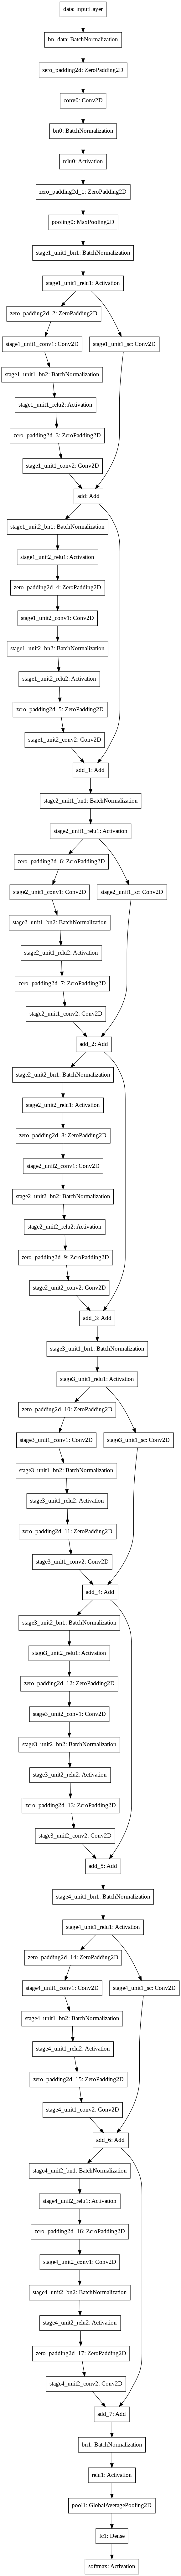

In [5]:
# Print ResNet18 Model architecture
tf.keras.utils.plot_model(
    Frozen_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

***
<a id="LayerFreezing"></a>
# 2. Freezing Layers in ResNet18 model

In [6]:
# Find total number of layers in ResNet18
num_layers = len(Frozen_model.layers)
print(num_layers)

89


In [7]:
# Start out by Freezing all layers
for layer_idx in range(num_layers):
  Frozen_model.layers[layer_idx].trainable = False
  unFrozen_model.layers[layer_idx].trainable = False

In [8]:
# My frozen model contains most of the initial layers Frozen, as it is common to do during transfer learning.
# A completely frozen model does not have the ability to learn
for layer_idx in range(75, num_layers):
  Frozen_model.layers[layer_idx].trainable = True
  
n_trainable_variables = len(Frozen_model.trainable_variables)
n_non_trainable_variables = len(Frozen_model.non_trainable_variables)
print("\n Before freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 Before freezing:
	 Number of trainable variables:  10 
	 Number of non trainable variables:  88


In [9]:
# For my unfrozen model I went through all trainable layers and unfroze them.
for layer_idx in range(num_layers):
  unFrozen_model.layers[layer_idx].trainable = True

n_trainable_variables = len(unFrozen_model.trainable_variables)
n_non_trainable_variables = len(unFrozen_model.non_trainable_variables)
print("\n Before freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 Before freezing:
	 Number of trainable variables:  60 
	 Number of non trainable variables:  38


In [10]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
# 1a. Sequential Model Formation
# new_Frozen_model = tf.keras.Sequential([Frozen_model,
#                                         tf.keras.layers.Flatten(),
#                                         tf.keras.layers.Dense(64),
#                                         tf.keras.layers.Dropout(0.3),
#                                         tf.keras.layers.Dense(10, activation='softmax')
#                                         ])

# new_unFrozen_model = tf.keras.Sequential([Frozen_model,
#                                         tf.keras.layers.Flatten(),
#                                         tf.keras.layers.Dense(64),
#                                         tf.keras.layers.Dropout(0.3),
#                                         tf.keras.layers.Dense(10, activation='softmax')
#                                         ])
# 1b. Functional Model Formation
output = Frozen_model.get_layer('pool1').output
flatten_output = Flatten()(output)
new_output = Dense(64, activation='relu', name='Dense_output_layers')(flatten_output)
new_output = Dropout(0.3)(new_output)
new_output = Dense(10, activation='softmax', name='softmax_output_layers')(new_output)
new_Frozen_model = Model(inputs=Frozen_model.input, outputs=new_output)

output = unFrozen_model.get_layer('pool1').output
flatten_output = Flatten()(output)
new_output = Dense(64, activation='relu', name='Dense_output_layers')(flatten_output)
new_output = Dropout(0.3)(new_output)
new_output = Dense(10, activation='softmax', name='softmax_output_layers')(new_output)
new_unFrozen_model = Model(inputs=unFrozen_model.input, outputs=new_output)

# confirm changes through model summary
new_Frozen_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 96, 96, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

### 2c. Model Compilation

In [11]:
# Model Compilation
base_learning_rate = 0.0001
new_Frozen_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])    

new_unFrozen_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])   

***
<a id="Stl10_Dataset"></a>
# 3. Load Stl10 Datasets
### Since we are using transfer learning between the imagenet trained ResNet18 and the Stl10 dataset it is important to compare the overlap of prediction classes contained between the two datasets. If classes contained in the Stl10 matched 1:1 to the imagenet dataset, training can go much faster with just a few epochs, since the class has already been pretrained and the 'neuron connections' are already trained to predict that class. On the flipside, if classess between the two trained models are different, it is recommended to unfreeze more layers so that the model can adapt, train effectively and predict that new class for which it has not been previously trained on.

In [12]:
pip install extra-keras-datasets

In [13]:
# load dataset into a training and test dataset, that contain imgages
# and the lables for each image.
from extra_keras_datasets import stl10
(training_ds, training_labels), (test_ds, test_labels) = stl10.load_data()

INFO:root:Loading dataset = stl-10


2851454976/2851452331 [==============================] - 41s 0us/step


In [14]:
# Standarize images
X_train, X_test = training_ds / 255.0, test_ds / 255.0

In [15]:
# Dataset labels appear in the range 1-10. 
# Here I simply change label 10 to label 0.
training_labels[training_labels==10]=0
test_labels[test_labels==10]=0

In [16]:
Frozen_history = new_Frozen_model.fit(X_train[...,np.newaxis], training_labels,batch_size=64, epochs=60, validation_data=(X_test, test_labels))

Epoch 1/60
79/79 [==============================] - ETA: 0s - loss: 1.9178 - accuracy: 0.2838WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_test_batch_end` time: 0.0177s). Check your callbacks.


79/79 [==============================] - 7s 83ms/step - loss: 1.9178 - accuracy: 0.2838 - val_loss: 2.3791 - val_accuracy: 0.1004
Epoch 2/60
79/79 [==============================] - 4s 51ms/step - loss: 1.7095 - accuracy: 0.3590 - val_loss: 2.7981 - val_accuracy: 0.1000
Epoch 3/60
79/79 [==============================] - 4s 51ms/step - loss: 1.6279 - accuracy: 0.3900 - val_loss: 4.0408 - val_accuracy: 0.1000
Epoch 4/60
79/79 [==============================] - 4s 51ms/step - loss: 1.5720 - accuracy: 0.4184 - val_loss: 4.0699 - val_accuracy: 0.1053
Epoch 5/60
79/79 [==============================] - 4s 51ms/step - loss: 1.5281 - accuracy: 0.4350 - val_loss: 2.4680 - val_accuracy: 0.1688
Epoch 6/60
79/79 [==============================] - 4s 51ms/step - loss: 1.4930 - accuracy: 0.4448 - val_loss: 2.2924 - val_accuracy: 0.1682
Epoch 7/60
79/79 [==============================] - 4s 51ms/step - loss: 1.4896 - accuracy: 0.4446 - val_loss: 2.2117 - val_accuracy: 0.1914
Epoch 8/60
79/79 [======

In [17]:
unFrozen_history = new_unFrozen_model.fit(X_train[...,np.newaxis], training_labels,batch_size=64, epochs=60, validation_data=(X_test, test_labels))

Epoch 1/60
79/79 [==============================] - ETA: 0s - loss: 1.3232 - accuracy: 0.5700WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0063s vs `on_test_batch_end` time: 0.0179s). Check your callbacks.


79/79 [==============================] - 10s 121ms/step - loss: 1.3232 - accuracy: 0.5700 - val_loss: 2.3623 - val_accuracy: 0.1000
Epoch 2/60
79/79 [==============================] - 7s 88ms/step - loss: 0.4032 - accuracy: 0.8658 - val_loss: 2.4270 - val_accuracy: 0.1000
Epoch 3/60
79/79 [==============================] - 7s 88ms/step - loss: 0.1968 - accuracy: 0.9418 - val_loss: 2.6038 - val_accuracy: 0.1190
Epoch 4/60
79/79 [==============================] - 7s 88ms/step - loss: 0.1169 - accuracy: 0.9670 - val_loss: 2.7241 - val_accuracy: 0.1324
Epoch 5/60
79/79 [==============================] - 7s 89ms/step - loss: 0.0746 - accuracy: 0.9802 - val_loss: 2.8411 - val_accuracy: 0.1121
Epoch 6/60
79/79 [==============================] - 7s 88ms/step - loss: 0.0453 - accuracy: 0.9892 - val_loss: 2.9286 - val_accuracy: 0.1465
Epoch 7/60
79/79 [==============================] - 7s 88ms/step - loss: 0.0336 - accuracy: 0.9932 - val_loss: 3.0360 - val_accuracy: 0.2109
Epoch 8/60
79/79 [====

***
<a id="Evaluation"></a>
#4. Model Evaluation 


##Results:
##4a. Training loss and training accuracy for first few epochs

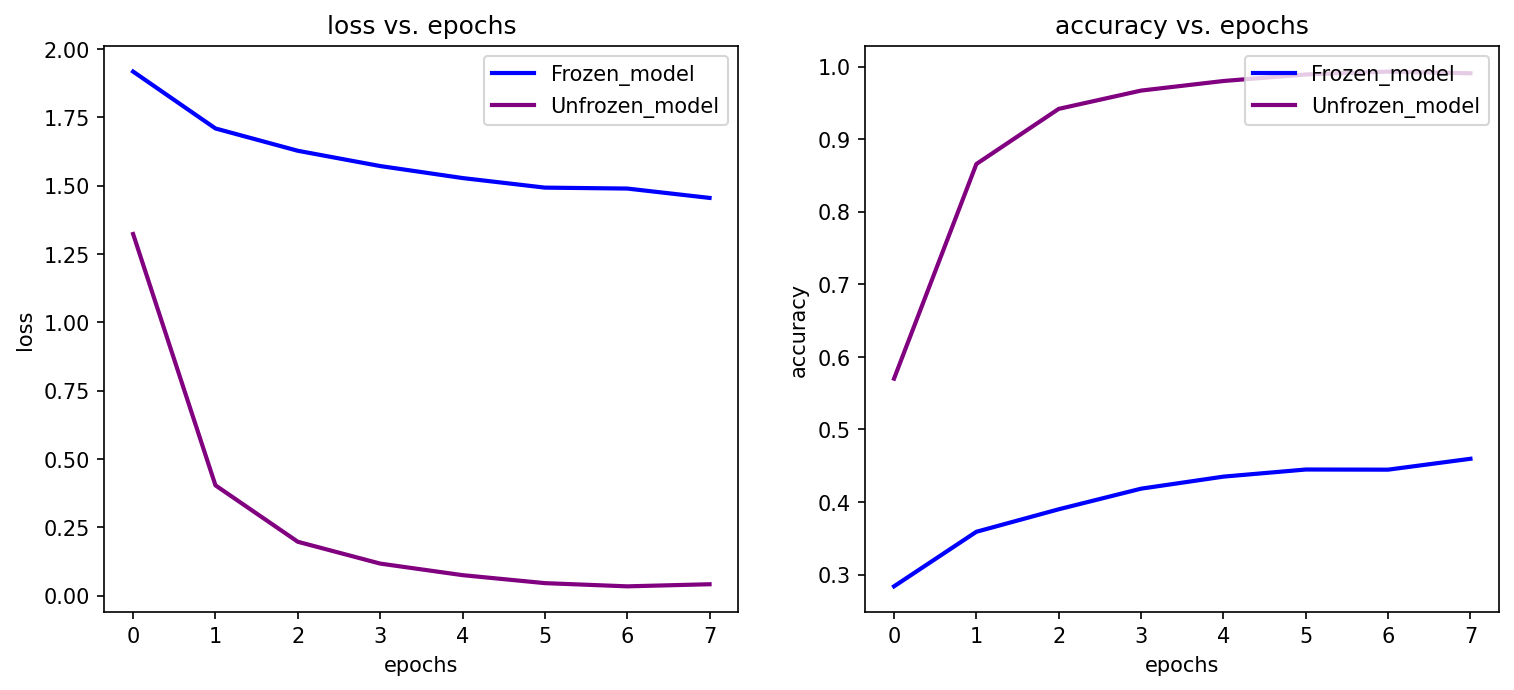

In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150

df1=pd.DataFrame({'Frozen_model': Frozen_history.history['loss'][:8], 'unFrozen_model': unFrozen_history.history['loss'][:8]})
df2=pd.DataFrame({'Frozen_model': Frozen_history.history['accuracy'][:8], 'unFrozen_model': unFrozen_history.history['accuracy'][:8]})
 
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
# multiple line plot
plt.plot('Frozen_model', data=df1, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df1, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.legend(loc='upper right')
plt.title('loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')

fig.add_subplot(122)
plt.plot('Frozen_model', data=df2, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df2, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

## 4b. Validation loss and validation accuracy for first few epochs

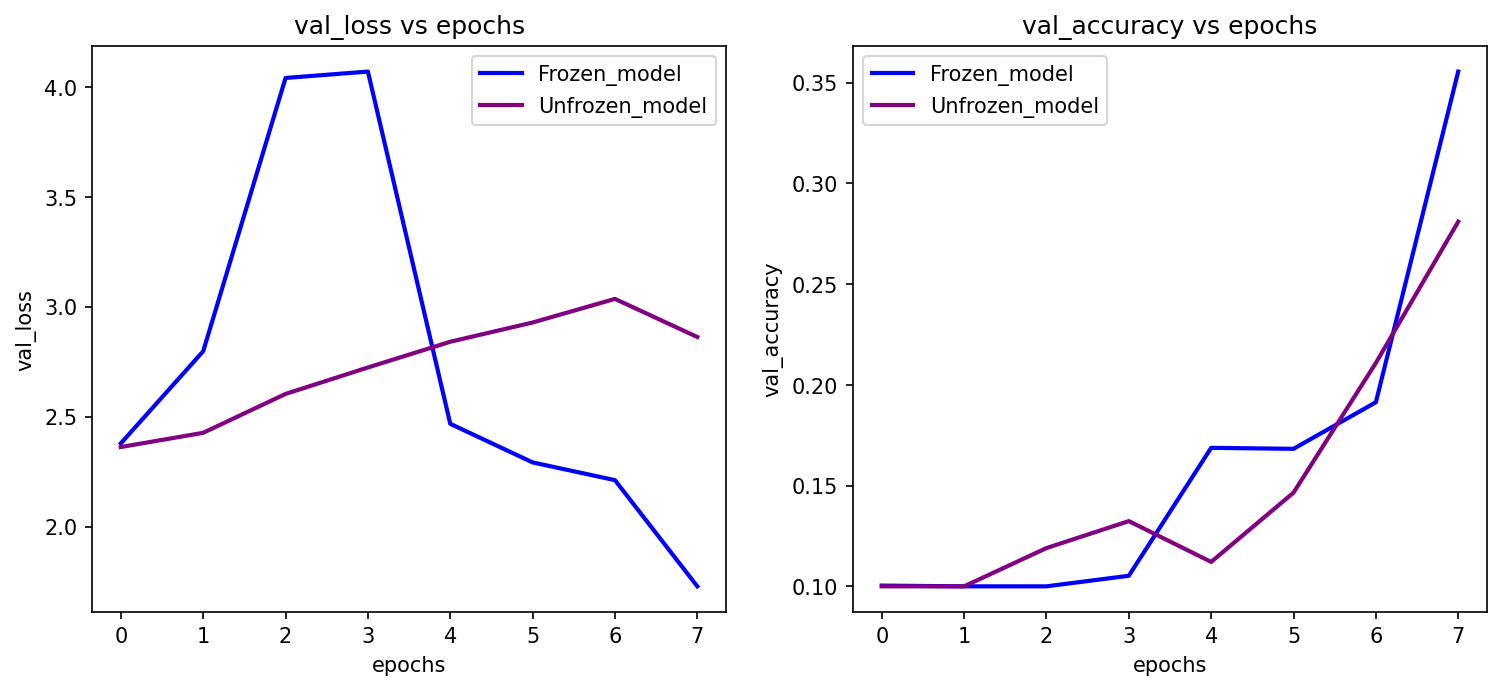

In [19]:
# Data
df1=pd.DataFrame({'Frozen_model': Frozen_history.history['val_loss'][:8], 'unFrozen_model': unFrozen_history.history['val_loss'][:8]})
df2=pd.DataFrame({'Frozen_model': Frozen_history.history['val_accuracy'][:8], 'unFrozen_model': unFrozen_history.history['val_accuracy'][:8]})

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
# multiple line plot
plt.plot('Frozen_model', data=df1, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df1, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('val_loss vs epochs')
plt.ylabel('val_loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

fig.add_subplot(122)


# multiple line plot
plt.plot('Frozen_model', data=df2, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df2, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('val_accuracy vs epochs')
plt.ylabel('val_accuracy')
plt.xlabel('epochs')
plt.legend()

## 4c. Training loss and training accuracy for total model training of 60 epochs

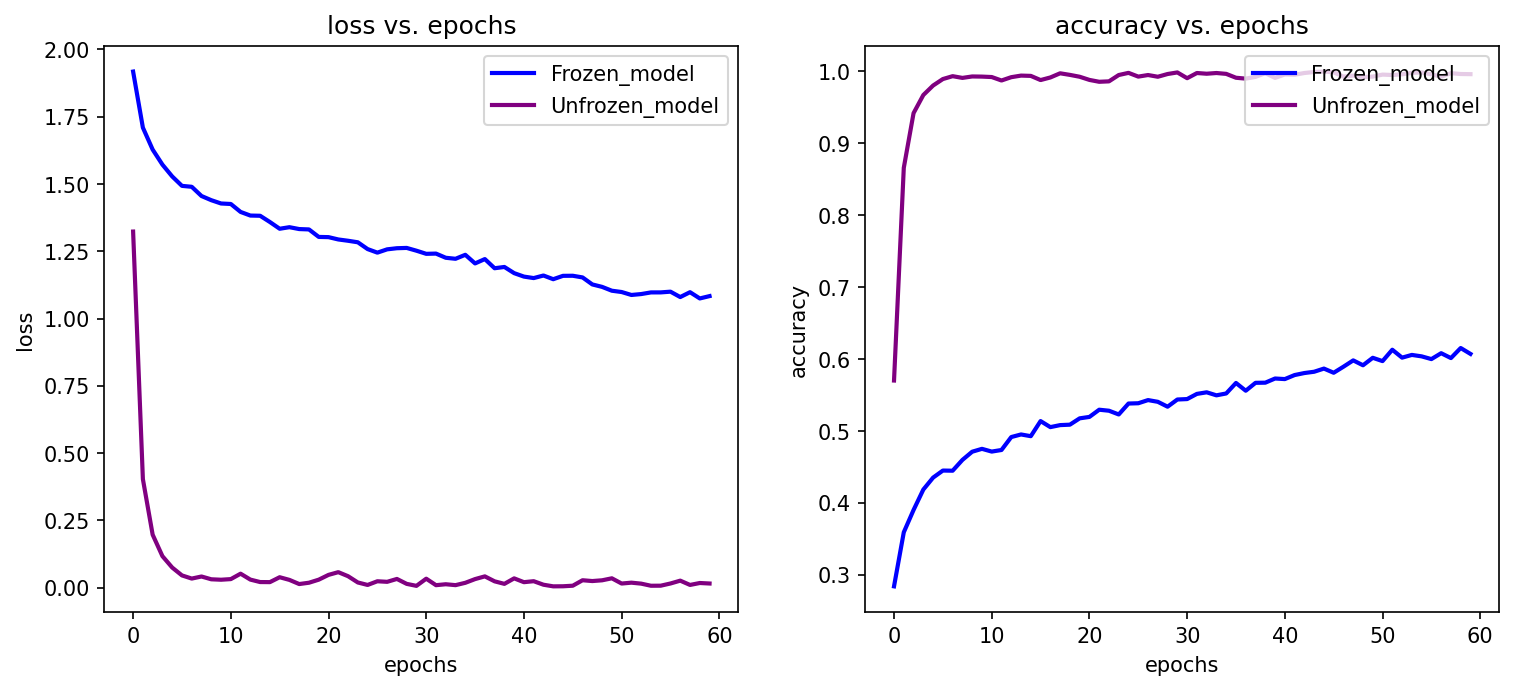

In [20]:
import numpy as np
import pandas as pd

df1=pd.DataFrame({'Frozen_model': Frozen_history.history['loss'], 'unFrozen_model': unFrozen_history.history['loss']})
df2=pd.DataFrame({'Frozen_model': Frozen_history.history['accuracy'], 'unFrozen_model': unFrozen_history.history['accuracy']})
 
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
# multiple line plot
plt.plot('Frozen_model', data=df1, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df1, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.legend(loc='upper right')
plt.title('loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')

fig.add_subplot(122)
plt.plot('Frozen_model', data=df2, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df2, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

## 4d. Validation loss and validation accuracy for total model training of 60 epochs

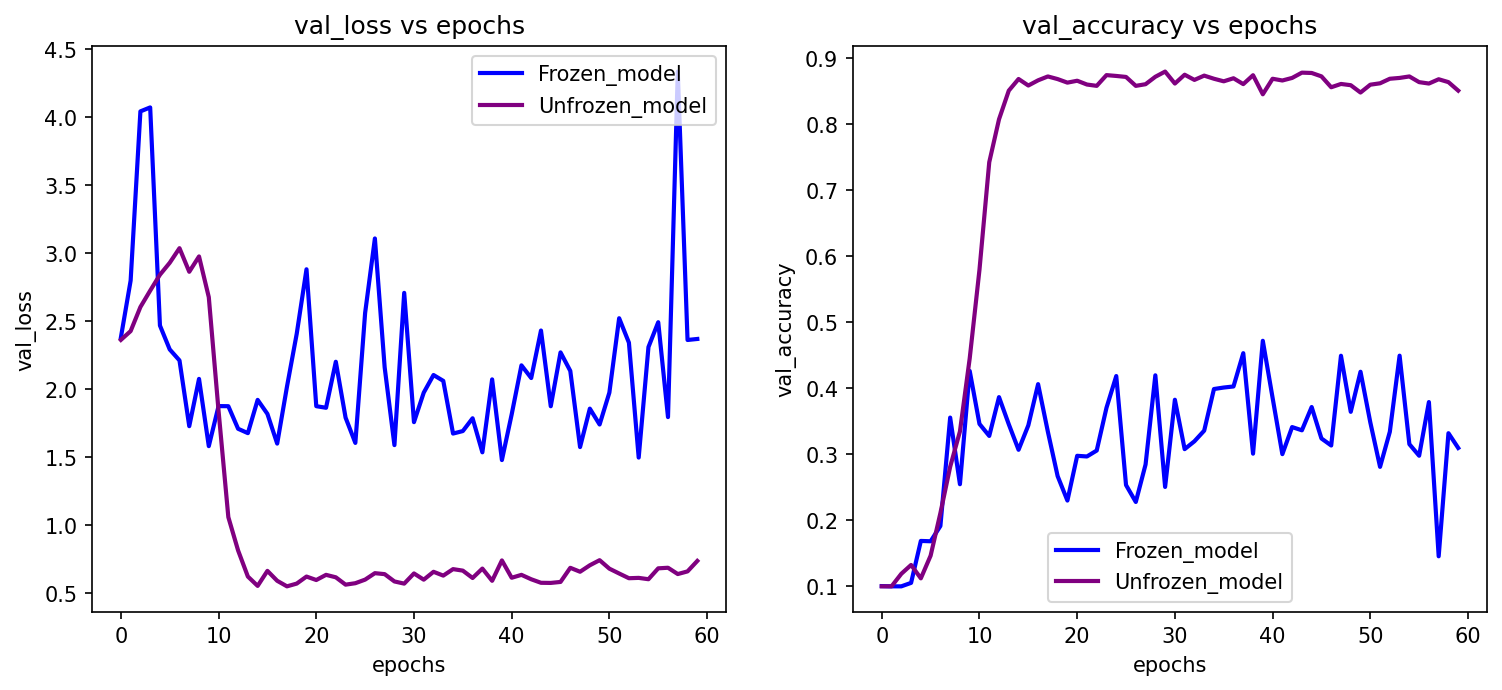

In [21]:
# Data
df1=pd.DataFrame({'Frozen_model': Frozen_history.history['val_loss'], 'unFrozen_model': unFrozen_history.history['val_loss']})
df2=pd.DataFrame({'Frozen_model': Frozen_history.history['val_accuracy'], 'unFrozen_model': unFrozen_history.history['val_accuracy']})

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
# multiple line plot
plt.plot('Frozen_model', data=df1, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df1, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('val_loss vs epochs')
plt.ylabel('val_loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

fig.add_subplot(122)


# multiple line plot
plt.plot('Frozen_model', data=df2, marker='', color='blue', linewidth=2, label="Frozen_model")
plt.plot('unFrozen_model', data=df2, marker='', color='purple', linewidth=2, label="Unfrozen_model")
plt.title('val_accuracy vs epochs')
plt.ylabel('val_accuracy')
plt.xlabel('epochs')
plt.legend()

***
<a id="Discussion"></a>
# 5. Results and Discussion:

## Results and Discussion
The ResNet18 pretrained model clearly shows that the pretrained model does better during the first few epochs of training. When a layer is frozen, it means that weights for that layer cannot be updated further during backpropagation. Since, all the initial weights stay constant, the backpropagation focuses on the new output layers, and it is able to makbetter prediction faster. Ultimately, this results in shorter computation time and a model that is trained much faster. However, it is important to note that if computation time is not a limitation, training a model where we unfreeze all the layers can result in a model that performs better and results in better accuracy. Because all the weights for all the layers are getting updated ( fine-tuning for a pre-trained model with a low learning rate), we are able to achieve overall better accuracy. 
### Key Takeaways:
#### 1. Pretrained models is a powerful technique that allows us to train models faster by leveraging models that have been pre-trained on a similar type of problem.
#### 2. Freezing layers allows us to cut computation time and focus training (weight update) on output layers that where added.
#### 3. Unfreezing layers can result in model training taking longer but can result in overall better accuracy by the end of model training.